In [1]:
import torch.nn as nn
import torch
import gymnasium as gym
import math
from torch import Tensor
from typing import Dict
from stable_baselines3.common.torch_layers import create_mlp


class MinMaxScaler:
    def __init__(self, min: float, max: float):
        self.min = min
        self.max = max
        self.divider = max - min

    def transform(self, x):
        return (x - self.min) / self.divider

    def inverse_transform(self, x):
        return x * self.divider + self.min

class CustomExtractor(nn.Module):
    def __init__(self, observation_space: gym.Space, features_dim: int = 32, net_arch=[32, 32, 32]) -> None:
        super().__init__()
        self.observation_space = observation_space
        self.scalers = {k: MinMaxScaler(v.low[0], v.high[0]) for k, v in self.observation_space.items()}
        self.input_dim = sum([math.prod(v.shape) for v in self.observation_space.values()])
        self.features_dim = features_dim
        self.model = nn.Sequential(*create_mlp(self.input_dim, self.features_dim, net_arch))

    def obs2vec(self, observation: Dict[str, Tensor]) -> Tensor:
        observation = {k: self.scalers[k].transform(observation[k]) for k in self.observation_space.keys()}
        input = torch.cat([v.flatten(start_dim=1) for v in observation.values()], dim=1)
        return input

    def forward(self, observation: Dict[str, Tensor]) -> Tensor:
        input = self.obs2vec(observation)
        z = self.model(input)
        return z

class Decoder(nn.Module):
    def __init__(self, features_dim: int, output_dim: int, device: str, net_arch=[32, 32, 32]) -> None:
        super().__init__()
        self.model = nn.Sequential(*create_mlp(features_dim, output_dim, net_arch)).to(device)

    def forward(self, z: Tensor) -> Tensor:
        return self.model(z)

class Trainer:
    def __init__(self, extractor: CustomExtractor, decoder: Decoder, lr: float = 1e-3) -> None:
        self.extractor = extractor
        self.decoder = decoder
        self.lr = lr
        self.loss = nn.functional.mse_loss
        self.optimizer = torch.optim.Adam(list(self.extractor.parameters()) + list(self.decoder.parameters()), lr=lr)

    def train_step(self, observation: Dict[str, Tensor]) -> float:
        self.optimizer.zero_grad()

        input = self.extractor.obs2vec(observation)
        z = self.extractor.model(input)
        restored = self.decoder.model(z)

        loss = self.loss(restored, input)

        loss.backward()
        self.optimizer.step()

        return loss.item()

In [2]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from pursuit import PursuitEnv
from stable_baselines3.common.callbacks import CheckpointCallback

env = make_vec_env(lambda: PursuitEnv(render=True), n_envs=1)
policy_kwargs = {
    "features_extractor_class": CustomExtractor,
    "features_extractor_kwargs": {},
}
model = PPO("MultiInputPolicy", policy_kwargs=policy_kwargs, env=env, device="cuda:0")
extractor = model.policy.features_extractor
decoder = Decoder(extractor.features_dim, extractor.input_dim, model.device)
trainer = Trainer(extractor, decoder)
vec_env = model.get_env()

In [3]:
from collections import defaultdict
import numpy as np


BATCH_SIZE = 2 ** 14
N_STEPS = 1000
losses = []

for iteration_id in range(N_STEPS):
    data = defaultdict(list)
    for i in range(BATCH_SIZE):
        observation = env.observation_space.sample()
        for k, v in observation.items():
            data[k].append(v)
    for k, v in data.items():
        data[k] = torch.FloatTensor(np.vstack(v)).to(model.device)
    loss = trainer.train_step(data)
    losses.append(loss)
    print(f"{iteration_id} / {N_STEPS}, loss: {loss}")

0 / 1000, loss: 0.35361289978027344
1 / 1000, loss: 0.34701138734817505
2 / 1000, loss: 0.3393316864967346
3 / 1000, loss: 0.33352911472320557
4 / 1000, loss: 0.32770881056785583
5 / 1000, loss: 0.3218032717704773
6 / 1000, loss: 0.3172129690647125
7 / 1000, loss: 0.3112923800945282
8 / 1000, loss: 0.304605633020401
9 / 1000, loss: 0.3000003397464752
10 / 1000, loss: 0.2922298312187195
11 / 1000, loss: 0.28469759225845337
12 / 1000, loss: 0.27998197078704834
13 / 1000, loss: 0.2703356146812439
14 / 1000, loss: 0.2604755163192749
15 / 1000, loss: 0.25082024931907654
16 / 1000, loss: 0.2394816130399704
17 / 1000, loss: 0.22786010801792145
18 / 1000, loss: 0.215376079082489
19 / 1000, loss: 0.2010337859392166
20 / 1000, loss: 0.18661727011203766
21 / 1000, loss: 0.16949883103370667
22 / 1000, loss: 0.15375961363315582
23 / 1000, loss: 0.1351412683725357
24 / 1000, loss: 0.11919370293617249
25 / 1000, loss: 0.10362356901168823
26 / 1000, loss: 0.09231064468622208
27 / 1000, loss: 0.0856010

KeyboardInterrupt: 

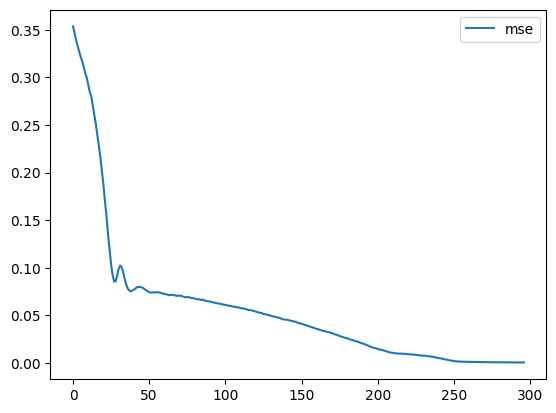

In [4]:
import matplotlib.pyplot as plt

plt.plot(losses, label="mse")
plt.legend()

In [5]:
model.save("pretrained_encoder.zip")

In [12]:
with open("loss_history.txt", "w") as f:
    f.writelines(list(map(lambda x : str(x) + "\n", losses)))